In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import h5py 
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random
import copy
from scipy.io import savemat

## Load datasets
1. Load noisy datasets to train the mimmax_scaler
2. Load clean data to train MLPclean
3. Load noisy data to train MLPnoisy

In [2]:
all_snrs= np.arange(-20.0, 11, 5)
all_snrs= np.append(all_snrs, np.inf)
snr_training_weights= np.flip(len(all_snrs)-np.arange(len(all_snrs)))/len(all_snrs)
print(snr_training_weights)

root_data_dir= 'D:/Dropbox/Python/MLmodels/Datasets/CarModPow/PyData/'

# Load clean data 
train_test_dataset = h5py.File(root_data_dir + 'CarMod_data_clean.h5', "r")
data_x_clean_orig = np.array(train_test_dataset["data_CarMod_x"][:]) # your train set features
data_y_clean_orig = np.ravel(np.array(train_test_dataset["data_label_y"][:])) # your train set labels

print(f"pre-shape:data_x_clean_orig={data_x_clean_orig.shape}, data_y_clean_orig={data_y_clean_orig.shape}")
data_x_clean_orig = np.reshape(data_x_clean_orig,(data_x_clean_orig.shape[0],data_x_clean_orig.shape[1]*data_x_clean_orig.shape[2]))
print(f"post-shape:data_x_clean_orig={data_x_clean_orig.shape}, data_y_clean_orig={data_y_clean_orig.shape}")
# data_clean_fnames = np.ravel(np.array(train_test_dataset["data_filename"][:])) # your train set labels

train_inds, test_inds = train_test_split(np.arange(data_x_clean_orig.shape[0]), test_size=0.25, random_state=1)

all_train_x_orig = data_x_clean_orig[train_inds]
all_train_y_orig = data_y_clean_orig[train_inds]

# Load all SNR data 
for snr_value,snr_weight in zip(all_snrs[0:-1], snr_training_weights[0:-1]):
    print(f"SNR={snr_value} dB and weight = {snr_weight}")
    out_CarMod_data_file = root_data_dir + 'CarMod_data_SNR' + snr_value.astype('int').astype('str') + '.h5'    
    cur_dataset = h5py.File(out_CarMod_data_file, "r")
        
    cur_x = np.array(cur_dataset["data_CarMod_x"][:])
    cur_x = np.reshape(cur_x,(cur_x.shape[0],cur_x.shape[1]*cur_x.shape[2]))
    cur_y = np.ravel(np.array(cur_dataset["data_label_y"][:]))
    
    sample_inds_training, _= train_test_split(np.arange(len(train_inds)), test_size= 1-snr_weight, random_state=1)

    all_train_x_orig = np.concatenate((all_train_x_orig, cur_x[train_inds[sample_inds_training]]))
    all_train_y_orig = np.concatenate((all_train_y_orig, cur_y[train_inds[sample_inds_training]]))
    print(f"shape:cur={cur_x.shape},cur_subsamp={len(sample_inds_training)}, full={len(train_inds)}, all_train_x_orig={all_train_x_orig.shape},type={type(cur_x)}")

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(all_train_x_orig)

train_set_x_norm = minmax_scaler.transform(data_x_clean_orig)
all_train_x_norm = minmax_scaler.transform(all_train_x_orig)

X_train_clean, X_test_clean, y_train_clean, y_test_clean, train_inds, test_inds = train_test_split \
    (train_set_x_norm, data_y_clean_orig, np.arange(train_set_x_norm.shape[0]), test_size=0.25, random_state=1)
print(f"Type: X_train_clean={type(X_train_clean)}, y_train_clean={type(y_train_clean)}")
print(f"Shapes: X_train_clean={X_train_clean.shape}, y_train_clean={y_train_clean.shape}, X_test_clean={X_test_clean.shape}, y_test_clean={y_test_clean.shape}")

unq_vals, unq_counts = np.unique(y_train_clean, return_counts=True)
print(dict(zip(unq_vals,unq_counts)))
    


[0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
pre-shape:data_x_clean_orig=(1605, 67, 9), data_y_clean_orig=(1605,)
post-shape:data_x_clean_orig=(1605, 603), data_y_clean_orig=(1605,)
SNR=-20.0 dB and weight = 0.125
shape:cur=(1605, 603),cur_subsamp=150, full=1203, all_train_x_orig=(1353, 603),type=<class 'numpy.ndarray'>
SNR=-15.0 dB and weight = 0.25
shape:cur=(1605, 603),cur_subsamp=300, full=1203, all_train_x_orig=(1653, 603),type=<class 'numpy.ndarray'>
SNR=-10.0 dB and weight = 0.375
shape:cur=(1605, 603),cur_subsamp=451, full=1203, all_train_x_orig=(2104, 603),type=<class 'numpy.ndarray'>
SNR=-5.0 dB and weight = 0.5
shape:cur=(1605, 603),cur_subsamp=601, full=1203, all_train_x_orig=(2705, 603),type=<class 'numpy.ndarray'>
SNR=0.0 dB and weight = 0.625
shape:cur=(1605, 603),cur_subsamp=751, full=1203, all_train_x_orig=(3456, 603),type=<class 'numpy.ndarray'>
SNR=5.0 dB and weight = 0.75
shape:cur=(1605, 603),cur_subsamp=902, full=1203, all_train_x_orig=(4358, 603),type=<class

## Model #1: An SVM model (rbf kernels seem to work the best)

Unique values in y_test_pred=[0 1 2 3 4]
Unique values in y_train_clean=[0 1 2 3 4]
Training accuracy=0.9875311720698254
 Testing accuracy=0.9701492537313433



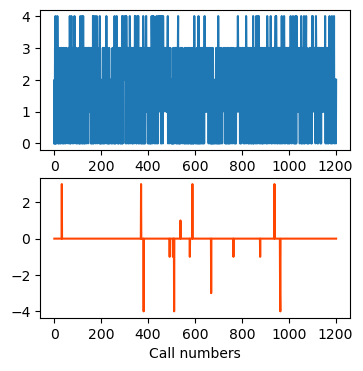

In [3]:
svm_model = svm.SVC(kernel='rbf').fit(X_train_clean, y_train_clean)
y_train_pred = svm_model.predict(X_train_clean)
y_test_pred = svm_model.predict(X_test_clean)

print(f"Unique values in y_test_pred={np.unique(y_test_pred)}")
print(f"Unique values in y_train_clean={np.unique(y_train_clean)}")

fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(y_train_clean)
ax[1].plot(y_train_clean-y_train_pred, color = "orangered")
ax[1].set_xlabel("Call numbers")

print(f"Training accuracy={np.sum(y_train_clean==y_train_pred)/len(y_train_pred)}\n Testing accuracy={np.sum(y_test_clean==y_test_pred)/len(y_test_pred)}\n")

## Model #2. Train an MLP 

In [4]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
MLPclean = Sequential(
    [
        Dense(10, activation = 'relu',   name = "L1"),
        Dense(5, activation = 'linear', name = "L2")
    ]
)

# Compile the model 
MLPclean.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy'],
)

# Fit the model 
MLPclean.fit(
    X_train_clean,y_train_clean,
    epochs=200
)

Epoch 1/200
38/38 [==============================] - 4s 3ms/step - loss: 0.4943 - accuracy: 0.8421
Epoch 2/200
38/38 [==============================] - 0s 2ms/step - loss: 0.1490 - accuracy: 0.9576
Epoch 3/200
38/38 [==============================] - 0s 3ms/step - loss: 0.1310 - accuracy: 0.9626
Epoch 4/200
38/38 [==============================] - 0s 2ms/step - loss: 0.0922 - accuracy: 0.9751
Epoch 5/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.9784
Epoch 6/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0715 - accuracy: 0.9809
Epoch 7/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0654 - accuracy: 0.9809
Epoch 8/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0806 - accuracy: 0.9767
Epoch 9/200
38/38 [==============================] - 0s 3ms/step - loss: 0.0701 - accuracy: 0.9784
Epoch 10/200
38/38 [==============================] - 0s 2ms/step - loss: 0.0461 - accuracy: 0.9900
Epoch 11/

## Test MLP accuracy for training and testing 

13/13 [==============================] - 0s 1000us/step
Unique values in y_train_clean=[0 1 2 3 4]
Unique values in y_test_pred=[0 1 2 3 4]
Training accuracy=1.0
 Testing accuracy=0.9751243781094527



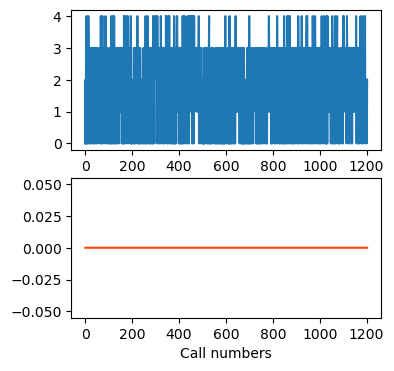

In [5]:
y_train_pred_NN = np.argmax(MLPclean.predict(X_train_clean), axis=1)
y_test_pred_NN = np.argmax(MLPclean.predict(X_test_clean), axis=1)

print(f"Unique values in y_train_clean={np.unique(y_train_pred_NN)}")
print(f"Unique values in y_test_pred={np.unique(y_test_pred_NN)}")

fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(y_train_clean)
ax[1].plot(y_train_clean-y_train_pred_NN, color = "orangered")
ax[1].set_xlabel("Call numbers")

print(f"Training accuracy={np.sum(y_train_clean==y_train_pred_NN)/len(y_train_clean)}\n Testing accuracy={np.sum(y_test_clean==y_test_pred_NN)/len(y_test_clean)}\n")

## Model #3. MLP cleaned on noisy calls 

In [6]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
MLPnoisy = Sequential(
    [
        Dense(10, activation = 'relu',   name = "L1"),
        Dense(5, activation = 'linear', name = "L2")
    ]
)

# Compile the model 
MLPnoisy.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy'],
)

# Fit the model 
MLPnoisy.fit(
    all_train_x_norm, all_train_y_orig,
    epochs=50,
)

Epoch 1/50
170/170 [==============================] - 1s 3ms/step - loss: 0.5725 - accuracy: 0.8113
Epoch 2/50
170/170 [==============================] - 0s 2ms/step - loss: 0.3283 - accuracy: 0.8932
Epoch 3/50
170/170 [==============================] - 0s 2ms/step - loss: 0.2791 - accuracy: 0.9041
Epoch 4/50
170/170 [==============================] - 0s 2ms/step - loss: 0.2821 - accuracy: 0.9002
Epoch 5/50
170/170 [==============================] - 0s 2ms/step - loss: 0.2352 - accuracy: 0.9194
Epoch 6/50
170/170 [==============================] - 0s 2ms/step - loss: 0.2275 - accuracy: 0.9222
Epoch 7/50
170/170 [==============================] - 0s 2ms/step - loss: 0.2121 - accuracy: 0.9270
Epoch 8/50
170/170 [==============================] - 0s 2ms/step - loss: 0.1984 - accuracy: 0.9336
Epoch 9/50
170/170 [==============================] - 0s 2ms/step - loss: 0.2213 - accuracy: 0.9229
Epoch 10/50
170/170 [==============================] - 0s 3ms/step - loss: 0.1995 - accuracy: 0.9288

## Test in different SNRs 

In [7]:
def test_MLP_snr(MLPmodel, minmax_scaler, snr_value, test_inds_clean):
    root_out_dir= 'D:/Dropbox/Python/MLmodels/Datasets/CarModPow/PyData/'
    if np.isinf(snr_value):
        out_CarMod_data_file = root_data_dir + 'CarMod_data_clean.h5'
    else:
        out_CarMod_data_file = root_out_dir + 'CarMod_data_SNR' + snr_value.astype('int').astype('str') + '.h5'
    cur_snr_dataset = h5py.File(out_CarMod_data_file, "r")
    print(cur_snr_dataset)
    data_x_orig = np.array(cur_snr_dataset["data_CarMod_x"][:]) # your train set features
    data_x_orig= np.reshape(data_x_orig, (data_x_orig.shape[0],data_x_orig.shape[1]*data_x_orig.shape[2]))
    data_y_orig = np.ravel(np.array(cur_snr_dataset["data_label_y"][:])) # your train set labels
    # data_fnames = np.ravel(np.array(cur_snr_dataset["data_filename"][:])) # your train set labels
    data_x_norm = minmax_scaler.transform(data_x_orig)

    X_test = data_x_norm[test_inds]
    y_test = data_y_orig[test_inds]
    # fName_test= data_fnames[test_inds]
    
    # rand_int = random.randint(0, len(test_fnames_clean))
    # clean_name = test_fnames_clean[rand_int].decode("utf-8")
    # noisy_name= fName_test[rand_int].decode("utf-8")

    # print(f"fnumber={rand_int} |-| clean={clean_name}|noisy={noisy_name}")
    # clean_name= clean_name[clean_name.rfind('/')+1:-3]
    # noisy_name= noisy_name[noisy_name.rfind('/')+1:-3]
    # if clean_name!=noisy_name:
    #     print("Should be same")
    y_test_pred_NN = np.argmax(MLPmodel.predict(X_test), axis=1)
    accuracy = np.sum(y_test==y_test_pred_NN)/len(y_test_clean)
    print(f"[SNR={snr_value} dB] Accuracy={accuracy}\n")
    
    return accuracy


test_accuracy_cleanMLP = np.zeros(all_snrs.shape)
test_accuracy_noisyMLP = np.zeros(all_snrs.shape)
for snr_value,iter in zip(all_snrs,range(len(all_snrs))):
    test_accuracy_cleanMLP[iter]= test_MLP_snr(MLPclean, minmax_scaler, snr_value, test_inds)
    test_accuracy_noisyMLP[iter]= test_MLP_snr(MLPnoisy, minmax_scaler, snr_value, test_inds)
    # print(f"SNR={snr_value} dB | Accuracy={test_accuracy[iter]}")

<HDF5 file "CarMod_data_SNR-20.h5" (mode r)>
13/13 [==============================] - 0s 1ms/step
[SNR=-20.0 dB] Accuracy=0.05472636815920398

<HDF5 file "CarMod_data_SNR-20.h5" (mode r)>
13/13 [==============================] - 0s 917us/step
[SNR=-20.0 dB] Accuracy=0.373134328358209

<HDF5 file "CarMod_data_SNR-15.h5" (mode r)>
13/13 [==============================] - 0s 1000us/step
[SNR=-15.0 dB] Accuracy=0.07462686567164178

<HDF5 file "CarMod_data_SNR-15.h5" (mode r)>
13/13 [==============================] - 0s 1000us/step
[SNR=-15.0 dB] Accuracy=0.6169154228855721

<HDF5 file "CarMod_data_SNR-10.h5" (mode r)>
13/13 [==============================] - 0s 1ms/step
[SNR=-10.0 dB] Accuracy=0.08706467661691543

<HDF5 file "CarMod_data_SNR-10.h5" (mode r)>
13/13 [==============================] - 0s 1ms/step
[SNR=-10.0 dB] Accuracy=0.818407960199005

<HDF5 file "CarMod_data_SNR-5.h5" (mode r)>
13/13 [==============================] - 0s 1ms/step
[SNR=-5.0 dB] Accuracy=0.1417910447761194


## Plot results 

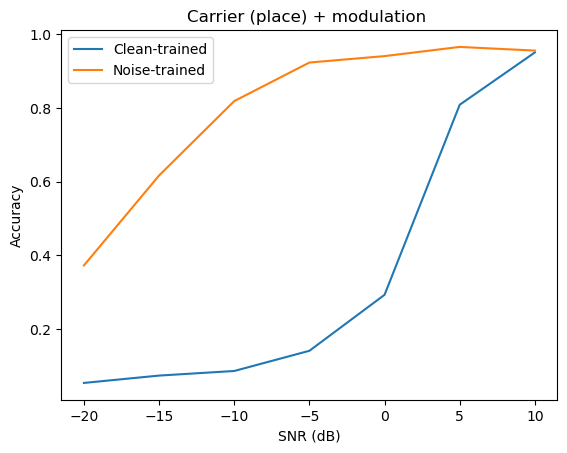

In [10]:
plot_snr= copy.deepcopy(all_snrs)
plot_snr[np.isinf(plot_snr)] = 15
plt.plot(all_snrs, test_accuracy_cleanMLP, label="Clean-trained")
plt.plot(all_snrs, test_accuracy_noisyMLP, label="Noise-trained")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Carrier (place) + modulation ")
plt.legend()

out_CarMod_classify_file = root_data_dir + 'CarMod_classify_out'
np.savez(out_CarMod_classify_file + '.npz', all_snrs=all_snrs, test_accuracy_noisyMLP=test_accuracy_noisyMLP, test_accuracy_cleanMLP=test_accuracy_cleanMLP)
mat_dict= {"all_snrs":all_snrs, "test_accuracy_noisyMLP":test_accuracy_noisyMLP, "test_accuracy_cleanMLP":test_accuracy_cleanMLP}
savemat(out_CarMod_classify_file + '.mat', mat_dict)